<a href="https://colab.research.google.com/github/M-Arashi/SASA-DS/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Jupyter Notebook demonstrates the forecasting of Bitcoin prices using deep learning techniques. It explores the effectiveness of three distinct recurrent neural network (RNN) architectures: SimpleRNN, LSTM, and GRU. The notebook focuses on preparing the data for training, implementing the models, evaluating their performance using metrics like Mean Squared Error (MSE) and Root Mean Squared Error (RMSE), and predicting future Bitcoin prices based on the most accurate model.

**Import Library**

In [1]:
import pandas as pd
import numpy as np
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from tensorflow.keras.layers import GRU
from datetime import date, timedelta, datetime
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'
stockname = 'NASDAQ'
symbol = 'BTC-USD'
import yfinance as yf
import seaborn as sb

**Get Data**

In [2]:
df = yf.download(symbol, start=start_date, end=end_date)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2024-06-23,64248.964844,64491.703125,63180.796875,63180.796875,63180.796875,11170471802
2024-06-24,63173.351562,63292.527344,58601.699219,60277.414062,60277.414062,43152133651
2024-06-25,60266.281250,62258.261719,60239.750000,61804.640625,61804.640625,29201215431


Adj Close = Close columns

In [3]:
df=df.drop(columns=["Adj Close"])

ACF plot

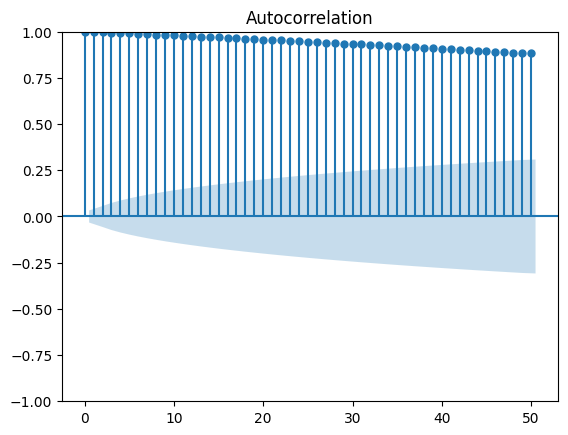

In [4]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df["Close"], lags=50)
plt.show()


**Correlation**

In [5]:
print(df.corr())

            Open      High       Low     Close    Volume
Open    1.000000  0.999539  0.999227  0.998949  0.651014
High    0.999539  1.000000  0.999082  0.999545  0.656757
Low     0.999227  0.999082  1.000000  0.999441  0.640806
Close   0.998949  0.999545  0.999441  1.000000  0.649760
Volume  0.651014  0.656757  0.640806  0.649760  1.000000


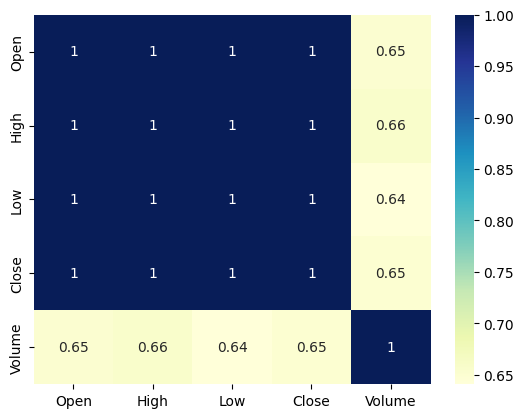

In [6]:
dataplot = sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)

In [7]:
df.describe()

,Open,High,Low,Close,Volume
count,3572.000000,3572.000000,3572.000000,3572.000000,3.572000e+03
mean,16823.078180,17208.185792,16411.600057,16838.987670,1.730570e+10
std,18716.905515,19142.438664,18248.608157,18727.735958,1.918924e+10
min,176.897003,211.731003,171.509995,178.102997,5.914570e+06
25%,1049.079956,1073.667542,1028.737549,1048.822510,2.477315e+08
50%,8839.410645,9049.521484,8664.161133,8836.713867,1.325379e+10
75%,27696.433594,28178.204590,27199.158691,27708.610352,2.789680e+10
max,73079.375000,73750.070312,71334.093750,73083.500000,3.509679e+11


**Time series plot for Close Price**

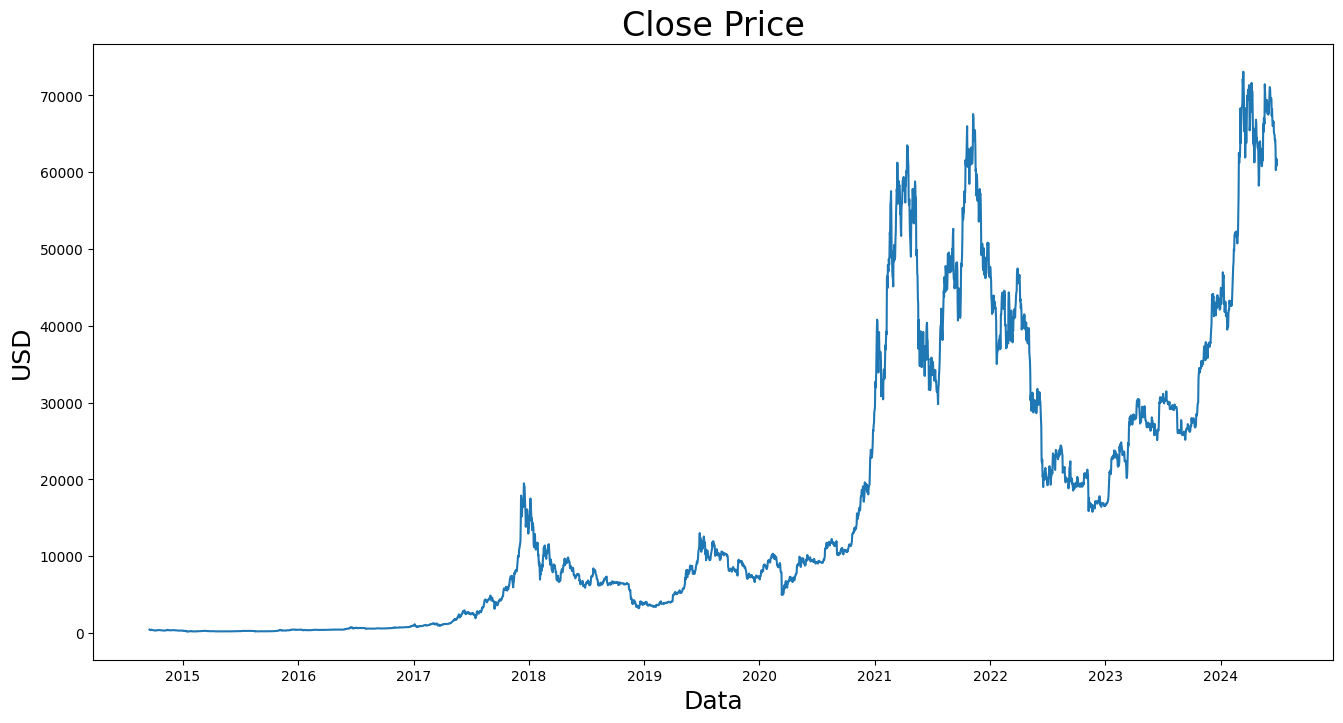

In [8]:
plt.figure(figsize=(16,8))
plt.title('Close Price', fontsize=24)
plt.plot(df['Close'])
plt.xlabel('Data', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.show()

**Reading Data and Splitting Into Train and Test , Validation**



this code snippet takes the "Close" price data from the original DataFrame, creates a new DataFrame with only that data, and then converts it into a NumPy array for use in the deep learning model.

In [9]:
#Creat a new dataframe with only Close Price
data = df.filter(['Close'])
#Convert the dataframe to numpy array
dataset = data.values

In [10]:
test_split=round(len(df)*0.10)
test_split

train_split=round(len(df)*0.70)
train_split

val_split=round(len(df)*0.20)
print(val_split)

df_for_training = df[:train_split]
df_for_validation = df[train_split:train_split + val_split]
df_for_testing = df[train_split + val_split:]



print(df_for_training.shape)
print(df_for_testing.shape)
print(df_for_validation.shape)

scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)
df_for_validation_scaled=scaler.transform(df_for_validation)
df_for_training_scaled

def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

trainX,trainY=createXY(df_for_training_scaled,30)
testX,testY=createXY(df_for_testing_scaled,30)
validX,validY=createXY(df_for_validation_scaled,30)
trainX[0]

print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)
print("validX Shape-- ",validX.shape)
print("validY Shape-- ",validY.shape)


714
(2500, 5)
(358, 5)
(714, 5)
trainX Shape--  (2470, 30, 5)
trainY Shape--  (2470,)
testX Shape--  (328, 30, 5)
testY Shape--  (328,)
validX Shape--  (684, 30, 5)
validY Shape--  (684,)


In [11]:
df_for_training

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100
...,...,...,...,...,...
2021-07-17,31397.308594,31935.945312,31223.990234,31533.068359,18895018942
2021-07-18,31533.884766,32398.996094,31215.492188,31796.810547,18787986667
2021-07-19,31800.011719,31885.859375,30563.734375,30817.832031,20434789545


In [12]:
df_for_validation

,Open,High,Low,Close,Volume
Date,,,,,
2021-07-22,32138.873047,32576.400391,31745.298828,32313.105469,19555230518
2021-07-23,32305.958984,33581.550781,32057.892578,33581.550781,22552046192
2021-07-24,33593.730469,34490.390625,33424.859375,34292.445312,21664706865
2021-07-25,34290.292969,35364.925781,33881.835938,35350.187500,20856685287
2021-07-26,35384.031250,40499.675781,35287.312500,37337.535156,51022126212
...,...,...,...,...,...
2023-07-01,30471.847656,30641.289062,30328.865234,30590.078125,9086606733
2023-07-02,30587.269531,30766.140625,30264.019531,30620.769531,10533418042
2023-07-03,30624.515625,31375.613281,30586.513672,31156.439453,15271884873


In [13]:
df_for_testing

,Open,High,Low,Close,Volume
Date,,,,,
2023-07-06,30507.150391,31460.052734,29892.226562,29909.337891,21129219509
2023-07-07,29907.998047,30434.644531,29777.285156,30342.265625,13384770155
2023-07-08,30346.921875,30374.437500,30080.160156,30292.541016,7509378699
2023-07-09,30291.611328,30427.589844,30085.591797,30171.234375,7903327692
2023-07-10,30172.423828,31026.083984,29985.394531,30414.470703,14828209155
...,...,...,...,...,...
2024-06-23,64248.964844,64491.703125,63180.796875,63180.796875,11170471802
2024-06-24,63173.351562,63292.527344,58601.699219,60277.414062,43152133651
2024-06-25,60266.281250,62258.261719,60239.750000,61804.640625,29201215431


In [14]:
!pip install livelossplot

**Simple RNN**

Initializes a sequential model modelS.
Adds a SimpleRNN layer with 30 units, setting return_sequences=True to return sequences for the subsequent layers and specifying the input shape as (30, 5) where 30 is the time steps and 5 is the number of features.
Adds two more SimpleRNN layers with 30 units each, the last one with return_sequences=False.
Adds two Dense layers with 25 and 1 unit(s) respectively.
Compilation:

Compiles the model using the Adam optimizer and Mean Squared Error (MSE) loss.
Training:

Uses tf.keras.callbacks.EarlyStopping to monitor the loss and stop training if it doesn't improve after 2 epochs.
Fits the model (modelS) to the training data (trainX, trainY) with a batch size of 64, for 50 epochs. It also specifies the validation data (validX, validY) and includes the PlotLossesKeras() callback to visualize the training progress.

**input_shape=(30, 5)**

30: This indicates the number of time steps in the input data. In a sequential data format like time series or sequences, this value represents the length of the sequence that the model will consider at once.

5: This represents the number of features or variables present at each time step. Each of the 30 time steps in this case is associated with a vector of 5 values.



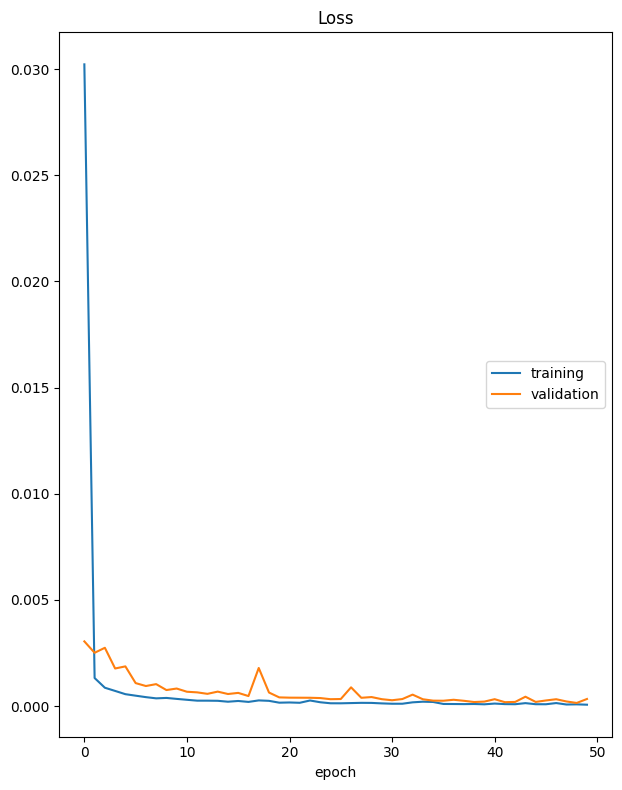

Loss
	training         	 (min:    0.000, max:    0.030, cur:    0.000)
	validation       	 (min:    0.000, max:    0.003, cur:    0.000)
39/39 [==============================] - 3s 80ms/step - loss: 6.6789e-05 - val_loss: 3.3639e-04


In [15]:
from livelossplot import PlotLossesKeras
tf.random.set_seed(42)

# Build that SimpleRNN model
modelS = Sequential()
modelS.add(SimpleRNN(30 , return_sequences=True, input_shape=(30, 5)))
modelS.add(SimpleRNN(30 , return_sequences=True))
modelS.add(SimpleRNN(30 , return_sequences=False))
modelS.add(Dense(25))
modelS.add(Dense(1))

# Compile model_1
modelS.compile(optimizer='Adam', loss='mse')

# Fit model_1
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history_1 = modelS.fit(trainX, trainY, batch_size=64, epochs=50, validation_data=(validX, validY),callbacks=[PlotLossesKeras()])



Text(0.5, 0, 'epochs')

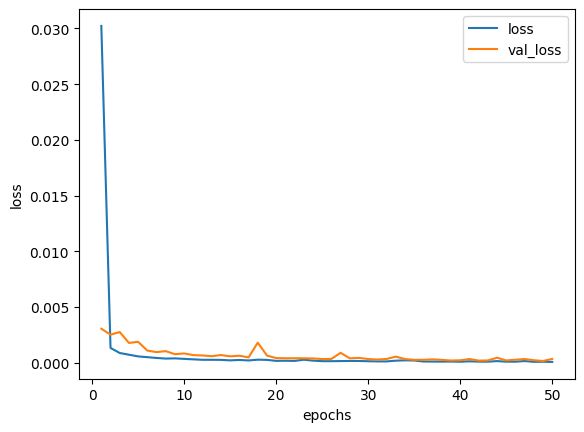

In [16]:
historyForPlot = pd.DataFrame(history_1.history)
historyForPlot.index += 1
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [17]:
# Get the model_1 predicted price values
predictions_1 = modelS.predict(testX)
predictions_v_1 = modelS.predict(validX)
predictions_t_1 = modelS.predict(trainX)

78/78 [==============================] - 1s 9ms/step


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(testY, predictions_1)
print("Mean Squared Error test: ", mse)

msev = mean_squared_error(validY, predictions_v_1)
print("Mean Squared Error Validation: ", msev)

mset = mean_squared_error(trainY, predictions_t_1)
print("Mean Squared Error Train : ", mset)

rmse = mean_squared_error(testY, predictions_1, squared=False)
print("Root Mean Squared Error test : ", rmse)

rmsev = mean_squared_error(validY, predictions_v_1, squared=False)
print("Root Mean Squared Error Validation : ", rmsev)

rmset = mean_squared_error(trainY, predictions_t_1, squared=False)
print("Root Mean Squared Error Train : ", rmset)

mae = mean_absolute_error(testY, predictions_1)
print("Mean Absolute Error test : ", mae)
maev = mean_absolute_error(validY, predictions_v_1)
print("Mean Absolute Error Validation : ", maev)
maet = mean_absolute_error(trainY, predictions_t_1)
print("Mean Absolute Error Train : ", maet)

Mean Squared Error test:  0.00042464971003177543
Mean Squared Error Validation:  0.00033639059561835807
Mean Squared Error Train :  0.00010919051291126213
Root Mean Squared Error test :  0.020607030597147552
Root Mean Squared Error Validation :  0.018340954054202253
Root Mean Squared Error Train :  0.010449426439344033
Mean Absolute Error test :  0.0172940790234646
Mean Absolute Error Validation :  0.015378261895083335
Mean Absolute Error Train :  0.007146108587191645


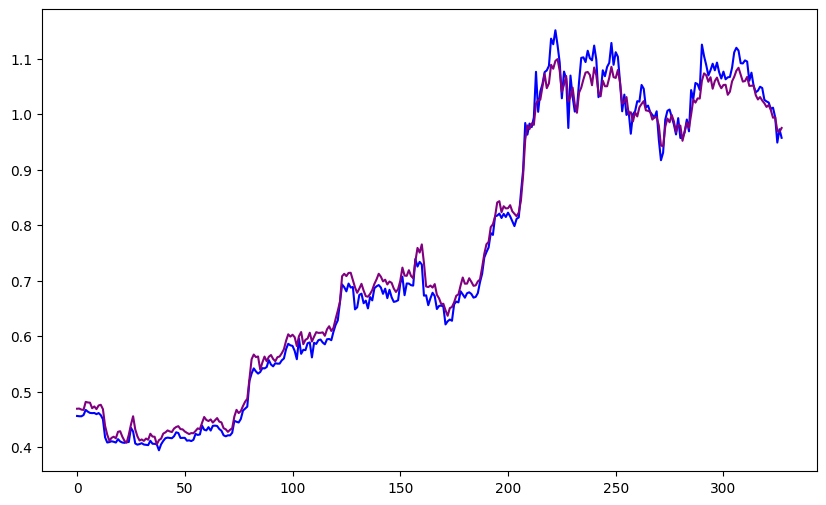

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(testY, label='Actual Values' , color='blue')
plt.plot(predictions_1, label='Model 1 Predictions', color='purple')

In [20]:
modelS.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 30, 30)            1080      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 30, 30)            1830      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 30)                1830      
                                                                 
 dense (Dense)               (None, 25)                775       
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 5541 (21.64 KB)
Trainable params: 5541 (21.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


LSTM

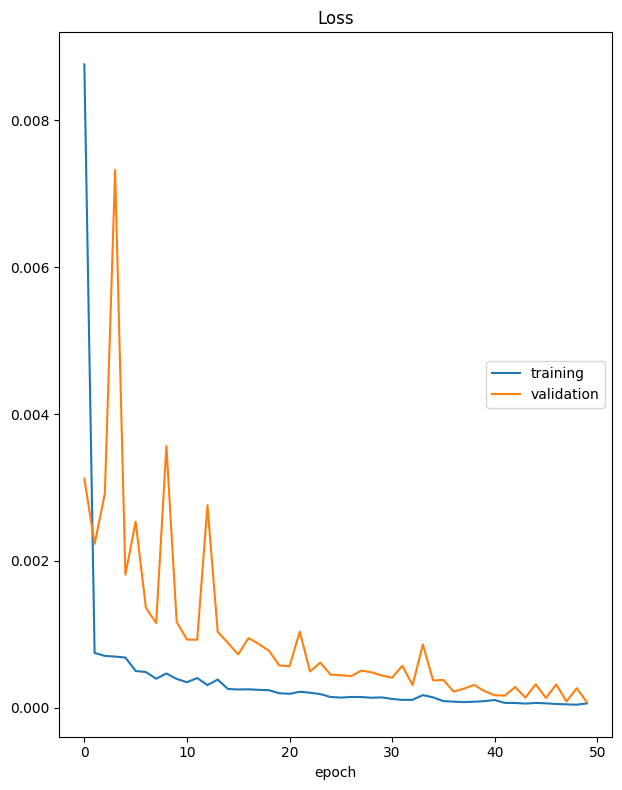

Loss
	training         	 (min:    0.000, max:    0.009, cur:    0.000)
	validation       	 (min:    0.000, max:    0.007, cur:    0.000)
39/39 [==============================] - 1s 18ms/step - loss: 6.0265e-05 - val_loss: 7.4599e-05


In [21]:
tf.random.set_seed(42)

modellstm = Sequential()
modellstm.add(LSTM(30, return_sequences=True, input_shape=((30,5))))
modellstm.add(LSTM(30, return_sequences=True))
modellstm.add(LSTM(30, return_sequences=False))
modellstm.add(Dense(25))
modellstm.add(Dense(1))

modellstm.compile(optimizer='Adam', loss='mse')

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history_2 = modellstm.fit(trainX, trainY, batch_size=64, epochs=50, validation_data=(validX, validY),callbacks=[PlotLossesKeras()])


Text(0.5, 0, 'epochs')

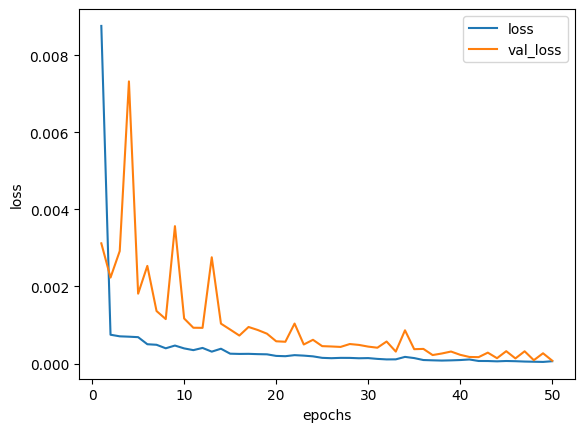

In [22]:
historyForPlot = pd.DataFrame(history_2.history)
historyForPlot.index += 1
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [23]:
predictions_2 = modellstm.predict(testX)

11/11 [==============================] - 2s 4ms/step


In [24]:
predictions_t_2 = modellstm.predict(trainX)

78/78 [==============================] - 0s 4ms/step


In [25]:
predictions_v_2 = modellstm.predict(validX)

22/22 [==============================] - 0s 4ms/step


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(testY, predictions_2)
print("Mean Squared Error Test: ", mse)

msev = mean_squared_error(validY, predictions_v_2)
print("Mean Squared Error Validation : ", msev)

mset = mean_squared_error(trainY, predictions_t_2)
print("Mean Squared Error Train : ", mset)


rmse = mean_squared_error(testY, predictions_2, squared=False)
print("Root Mean Squared Error Test : ", rmse)

rmsev = mean_squared_error(validY, predictions_v_2, squared=False)
print("Root Mean Squared Error Validation: ", rmsev)

rmset = mean_squared_error(trainY, predictions_t_2, squared=False)
print("Root Mean Squared Error Train : ", rmset)


mae = mean_absolute_error(testY, predictions_2)
print("Mean Absolute Error Test : ", mae)

maev = mean_absolute_error(validY, predictions_v_2)
print("Mean Absolute Error Validation : ", maev)

maet = mean_absolute_error(trainY, predictions_t_2)
print("Mean Absolute Error Train : ", maet)

Mean Squared Error Test:  0.00014545669743962314
Mean Squared Error Validation :  7.459889644002317e-05
Mean Squared Error Train :  3.40058067283414e-05
Root Mean Squared Error Test :  0.012060542999368774
Root Mean Squared Error Validation:  0.008637065267787616
Root Mean Squared Error Train :  0.0058314497964349656
Mean Absolute Error Test :  0.008669949459585123
Mean Absolute Error Validation :  0.006288346293017961
Mean Absolute Error Train :  0.0037800802852473356


In [27]:
modellstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 30)            4320      
                                                                 
 lstm_1 (LSTM)               (None, 30, 30)            7320      
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dense_2 (Dense)             (None, 25)                775       
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 19761 (77.19 KB)
Trainable params: 19761 (77.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


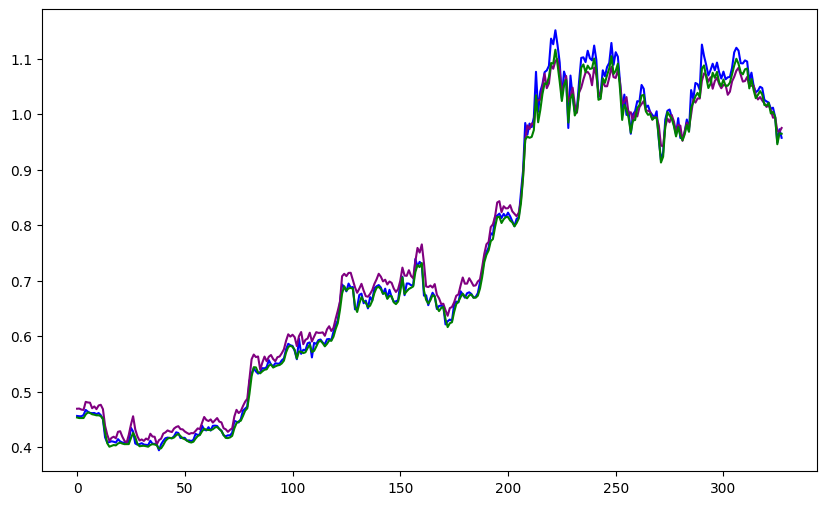

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(testY, label='Actual Values' , color='blue')
plt.plot(predictions_1, label='Model 1 Predictions', color='purple')
plt.plot(predictions_2, label='Model 2 Predictions', color='green')

GRU

In [29]:
tf.random.set_seed(42)

modelGRU = Sequential()
modelGRU = Sequential()
modelGRU.add(GRU(30, return_sequences=True, input_shape=(30,5)))
modelGRU.add(GRU(30, return_sequences=True))
modelGRU.add(GRU(30, return_sequences=False))
modelGRU.add(Dense(25))
modelGRU.add(Dense(1))
modelGRU.compile(optimizer='Adam', loss='mse')

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history_3 = modelGRU.fit(trainX, trainY, batch_size=64, epochs=50, validation_data=(validX, validY))

Epoch 1/50
39/39 [==============================] - 7s 33ms/step - loss: 0.0056 - val_loss: 0.0022
Epoch 2/50
39/39 [==============================] - 0s 10ms/step - loss: 3.0846e-04 - val_loss: 9.6022e-04
Epoch 3/50
39/39 [==============================] - 0s 10ms/step - loss: 2.3031e-04 - val_loss: 0.0015
Epoch 4/50
39/39 [==============================] - 0s 11ms/step - loss: 2.2496e-04 - val_loss: 9.0414e-04
Epoch 5/50
39/39 [==============================] - 0s 10ms/step - loss: 1.7479e-04 - val_loss: 5.0949e-04
Epoch 6/50
39/39 [==============================] - 0s 10ms/step - loss: 1.3670e-04 - val_loss: 6.2068e-04
Epoch 7/50
39/39 [==============================] - 0s 11ms/step - loss: 1.1283e-04 - val_loss: 4.5703e-04
Epoch 8/50
39/39 [==============================] - 0s 10ms/step - loss: 9.6676e-05 - val_loss: 2.9633e-04
Epoch 9/50
39/39 [==============================] - 0s 11ms/step - loss: 8.9883e-05 - val_loss: 3.5033e-04
Epoch 10/50
39/39 [==============================

Text(0.5, 0, 'epochs')

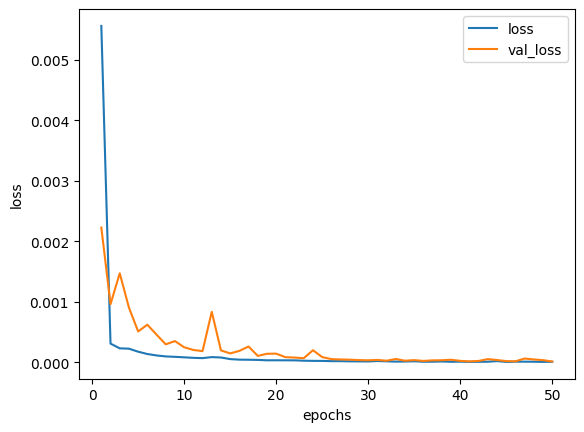

In [30]:
historyForPlot = pd.DataFrame(history_3.history)
historyForPlot.index += 1
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [31]:
predictions_3 = modelGRU.predict(testX)

11/11 [==============================] - 1s 4ms/step


In [32]:
predictions_v_3 = modelGRU.predict(validX)

22/22 [==============================] - 0s 4ms/step


In [33]:
predictions_t_3 = modelGRU.predict(trainX)

78/78 [==============================] - 0s 4ms/step


In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(testY, predictions_3)
print("Mean Squared Error Test : ", mse)

msev = mean_squared_error(validY, predictions_v_3)
print("Mean Squared Error Validation : ", msev)

mset = mean_squared_error(trainY, predictions_t_3)
print("Mean Squared Error Train : ", mset)


rmse = mean_squared_error(testY, predictions_3, squared=False)
print("Root Mean Squared Error Test : ", rmse)

rmsev = mean_squared_error(validY, predictions_v_3, squared=False)
print("Root Mean Squared Error Validation : ", rmsev)

rmset = mean_squared_error(trainY, predictions_t_3, squared=False)
print("Root Mean Squared Error Train : ", rmset)

mae = mean_absolute_error(testY, predictions_3)
print("Mean Absolute Error Test : ", mae)

maev = mean_absolute_error(validY, predictions_v_3)
print("Mean Absolute Error Validation : ", maev)

maet = mean_absolute_error(trainY, predictions_t_3)
print("Mean Absolute Error Train : ", maet)

Mean Squared Error Test :  5.923617958039704e-05
Mean Squared Error Validation :  1.314746238193542e-05
Mean Squared Error Train :  5.500327602211631e-06
Root Mean Squared Error Test :  0.0076965043740906845
Root Mean Squared Error Validation :  0.003625942964517702
Root Mean Squared Error Train :  0.002345277723897882
Mean Absolute Error Test :  0.004958921736583942
Mean Absolute Error Validation :  0.002404176378755262
Mean Absolute Error Train :  0.0013083919324347278


In [35]:
modelGRU.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 30)            3330      
                                                                 
 gru_1 (GRU)                 (None, 30, 30)            5580      
                                                                 
 gru_2 (GRU)                 (None, 30)                5580      
                                                                 
 dense_4 (Dense)             (None, 25)                775       
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 15291 (59.73 KB)
Trainable params: 15291 (59.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


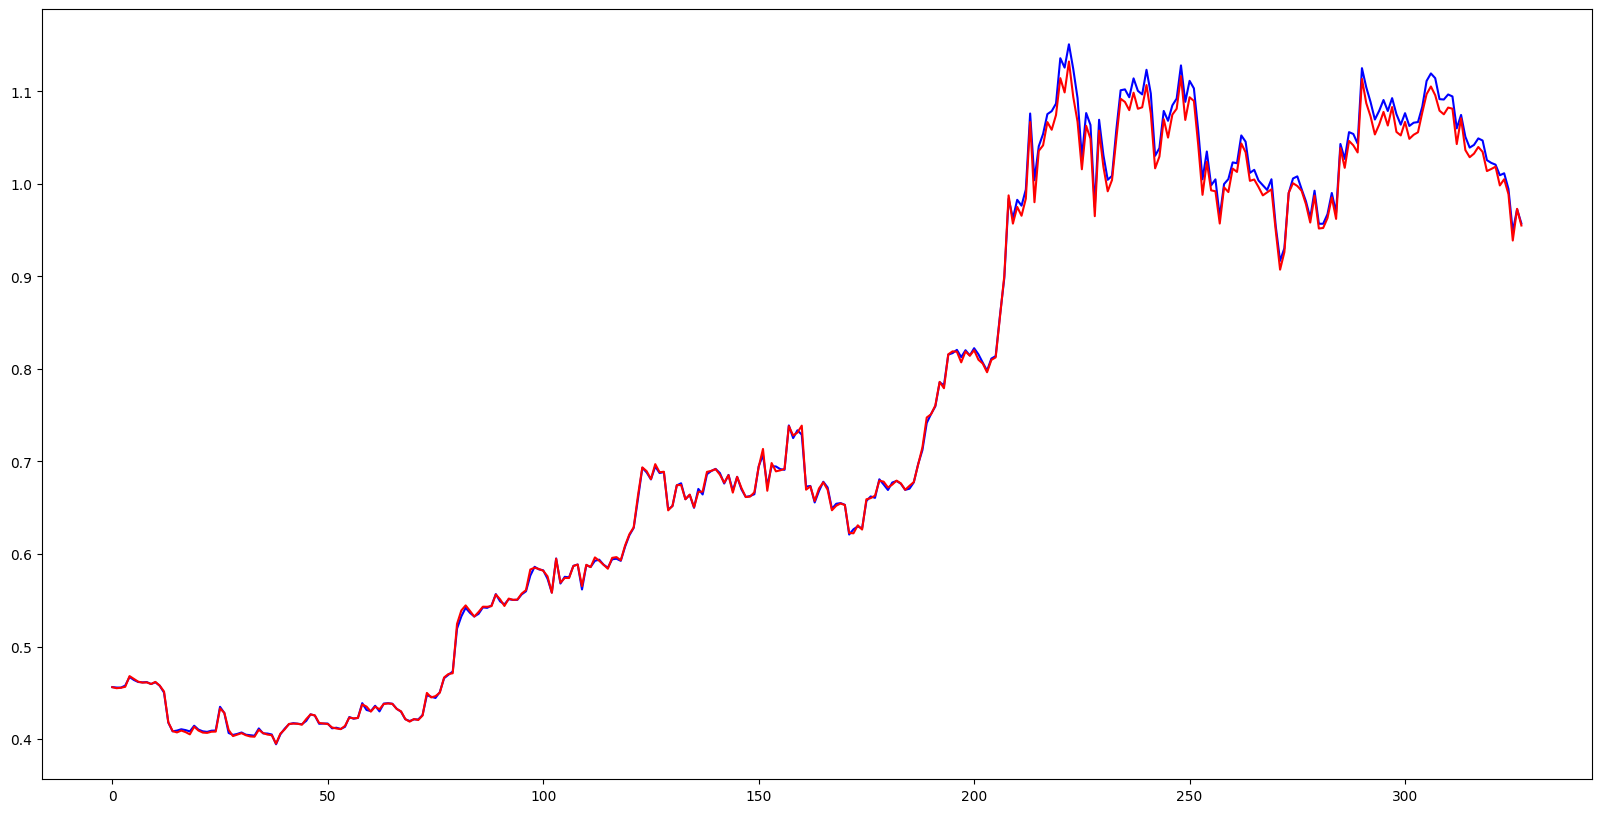

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(testY, label='Actual Values' , color='blue')
plt.plot(predictions_3, label='Model 3 Predictions', color='red')

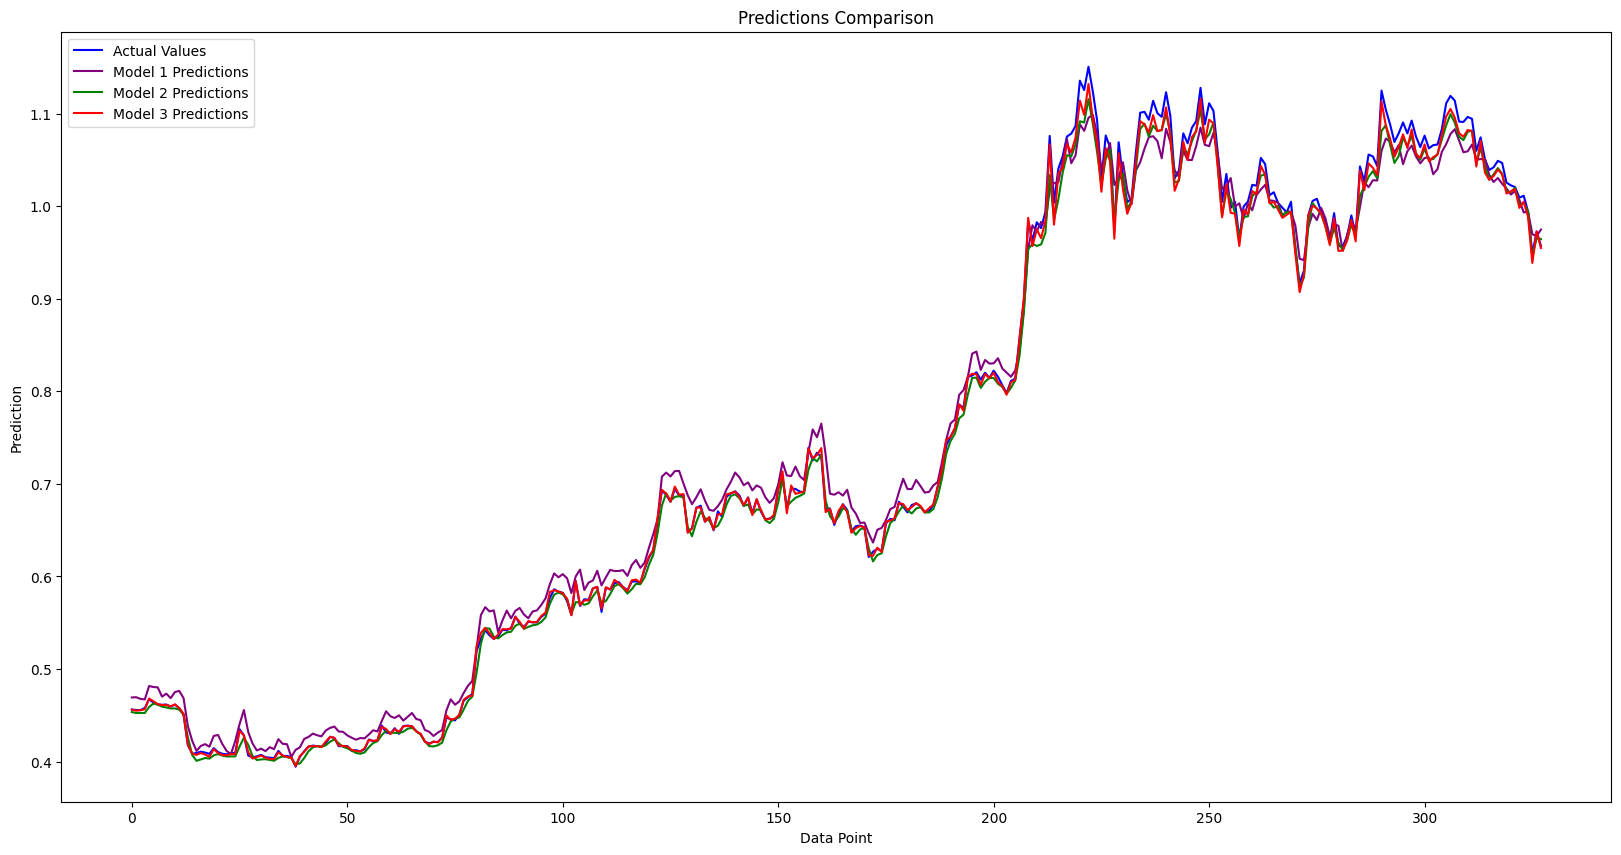

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(testY, label='Actual Values' , color='blue')
plt.plot(predictions_1, label='Model 1 Predictions', color='purple')
plt.plot(predictions_2, label='Model 2 Predictions', color='green')
plt.plot(predictions_3, label='Model 3 Predictions', color='red')
plt.title('Predictions Comparison')
plt.xlabel('Data Point')
plt.ylabel('Prediction')
plt.legend()
plt.show()


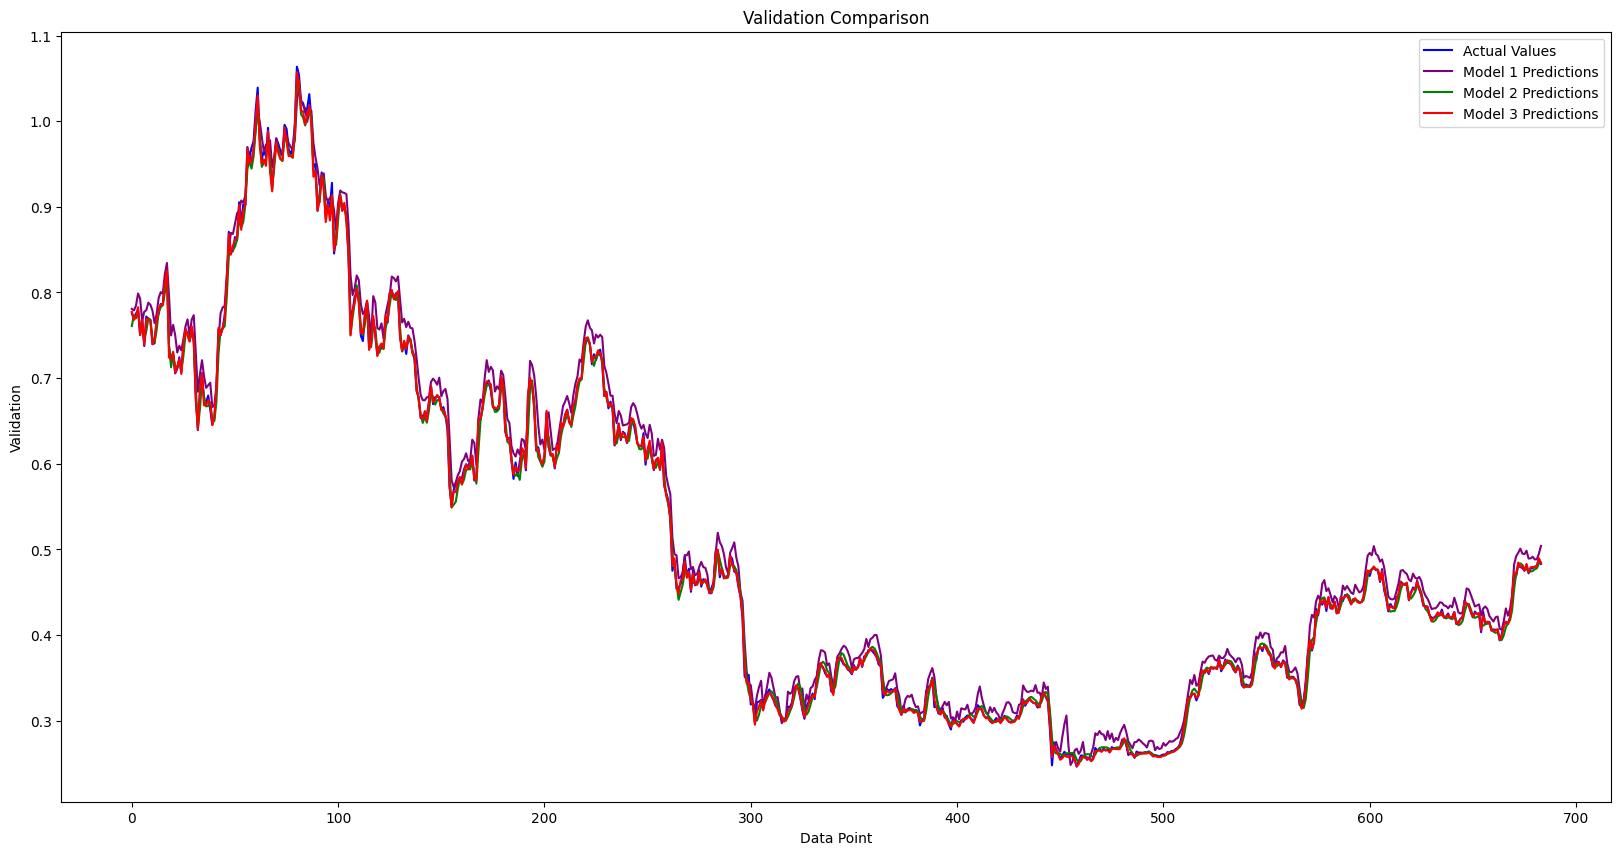

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(validY, label='Actual Values' , color='blue')
plt.plot(predictions_v_1, label='Model 1 Predictions', color='purple')
plt.plot(predictions_v_2, label='Model 2 Predictions', color='green')
plt.plot(predictions_v_3, label='Model 3 Predictions', color='red')
plt.title('Validation Comparison')
plt.xlabel('Data Point')
plt.ylabel('Validation')
plt.legend()
plt.show()

In [39]:
#Get the last 1 day closing price values and convert the datadrame to an array
last_1_days = data[-1:].values
# Scale the data to be values between 0 and 1
last_1_days_scaled = scaler.fit_transform(last_1_days)
# create an empty list
new_X_test = []
# Append the past 1 days
new_X_test.append(last_1_days_scaled)
# Convert the X_test data set to a numpy array
new_X_test = np.array(new_X_test)
# Reshape the data
new_X_test = np.reshape(new_X_test, (new_X_test.shape[0], new_X_test.shape[1], 1))
# Get the predicted scaled price
pred_price = modelGRU.predict(new_X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

1/1 [==============================] - 1s 805ms/step
[[61604.785]]
